In [85]:
import mitsuba as mi 
import drjit as dr 
import numpy as np
import matplotlib.pyplot as plt
mi.set_variant("llvm_ad_rgb")

In [86]:
from drjit.llvm import Float, UInt32

In [87]:
# Define multiple cdf s and pdf s to sample from. We will specify an index parameter 
# to choose the correct distribution.
pdf = np.array([[1,2,3,4,3,1,2,4,5,6,7],
                [1,4,1,4,4,5,2,3,5,5,1]])
pdf = pdf / np.sum(pdf, axis = 1)[:,np.newaxis]
cdf = np.cumsum(pdf, axis = 1) / np.sum(pdf, axis = 1)[:,np.newaxis]
# Add zero values to the beginning of the cdf.
cdf = np.hstack([np.zeros([pdf.shape[0],1]), cdf])

In [88]:
pdf = mi.TensorXf(pdf)
cdf = mi.TensorXf(cdf)
print(pdf.shape)
print(cdf.shape)

(2, 11)
(2, 12)


In [89]:
print(cdf)

TensorXf(shape=(2, 12))


In [90]:
# Do not forget to write @dr.syntax in the beginning of each function. 
# You can check drjit documentation for it.

def eval_pdf(x, index = UInt32(0)):
    n = pdf.shape[1]
    n_bin = dr.minimum(n-1, UInt32(x * n))
    # Get the index of the array for the corresponding index of cdf.
    i = n * index + n_bin
    return dr.gather(Float, pdf.array, i) * n

def eval_cdf(x, index = UInt32(0)):
    n = pdf.shape[1]
    x_n = x * n
    n_bin = dr.minimum(n-1, UInt32(x_n))
    # Residual value
    r = x_n - Float(n_bin)
    
    # Get the corresponding indices from different cdfs.
    i = (n +1) * index + n_bin
    cdf_low = dr.gather(Float, cdf.array, i)
    cdf_high = dr.gather(Float, cdf.array, i + 1)

    # Apply linear interpolation between cdf values.
    return cdf_low * (1 -r) + cdf_high * r

def sample(sample : Float, index = UInt32(0)):
    # Run bisection to apply inverse cdf.
    n = pdf.shape[1]
    low = dr.zeros(UInt32, dr.width(sample))
    high = dr.ones(UInt32, dr.width(sample)) * n

    # You should define your loops as while loops to run in the symbolic mode with drjit. 
    # Otherwise a new cuda kernel will be generated at each iteration which we don't want.
    # You can read the drjit documentation about how the loops are implemented.

    # We first find the correct bin to sample from.
    print(low, high)
    while (low+1) < high:
        middle =  (low + high) // 2
        # Evaluate the cdf for the corresponding distributions.
        i = (n +1) * index + middle
        cdf_val = dr.gather(Float, cdf.array, i)
        
        if sample < cdf_val:
            high = middle
        else:
            low = middle

    # Now we found the corect bin. We need to find the exact point by a linear interpolation as the cdf is linear.
    i = (n +1) * index + low 
    cdf_low = dr.gather(Float, cdf.array, i)
    cdf_high = dr.gather(Float, cdf.array, i+1)
    
    residual = sample - cdf_low

    return (Float(low) + residual / (cdf_high - cdf_low))/ n

In [93]:
# First plot the cdf and the pdf for a certain index.
n = 200
ind = 0
index = dr.ones(mi.UInt32, n) * ind
x = dr.arange(mi.Float, n) / n 
pdf_vals = eval_pdf(x, index)
cdf_vals = eval_cdf(x, index)

TypeError: UInt constructor expects: arbitrarily many values of type "int", a matching list/tuple, or a NumPy/PyTorch/TF/Jax array.

Text(0.5, 1.0, 'CDF')

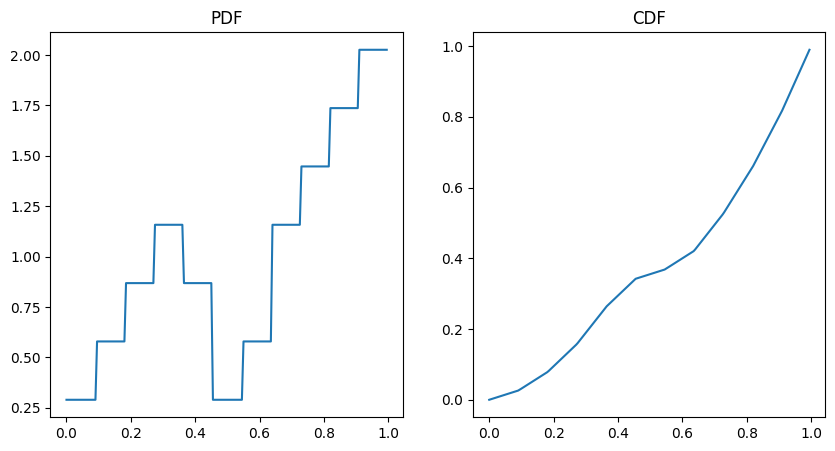

In [92]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.plot(x.numpy(), pdf_vals.numpy())
ax2.plot(x.numpy(), cdf_vals.numpy())
ax1.set_title("PDF")
ax2.set_title("CDF")

In [84]:
# Now lets check the sampling for a single bin.
n_points = 100000000
sampler = mi.PCG32(n_points)
index = dr.ones(UInt32, n_points) * ind
sampled = sample(sampler.next_float32(), index = index)

[0] [11]


Exception: To convert an Dr.Jit array into a boolean value, use a mask reduction operation such as drjit.all(), drjit.any(), drjit.none(). Special variants (drjit.all_nested(), etc.) are available for nested arrays.

NameError: name 'sampled' is not defined

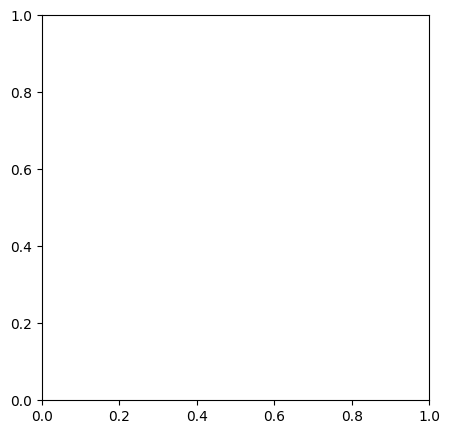

In [78]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.hist(sampled.numpy(), bins = 300, density = True);
ax.plot(x.numpy(), pdf_vals.numpy())
ax.set_title("PDF and the corresponding histogram")

In [82]:
# We now can not sample from diffent distrubutions. 
index = UInt32([0,2,4,5,6])
x = Float([0.21, 0.32, 0.5, 0.12, 0.87])
pdf_valss = eval_pdf(x, index)
cdf_valss = eval_cdf(x, index)
sampledd = sample(x, index)

Exception: To convert an Dr.Jit array into a boolean value, use a mask reduction operation such as drjit.all(), drjit.any(), drjit.none(). Special variants (drjit.all_nested(), etc.) are available for nested arrays.

In [11]:
sampled

[0.215709, 0.732519, 0.0236447, .. 99999994 skipped .., 0.771928, 0.963854, 0.771555]